In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.corpus import stopwords
import re
import string
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from afinn import Afinn

import pickle

In [2]:
# Import DataSet
review = pd.read_csv(r"C:\Users\aksha\Desktop\Internship\Ai Varient\Hotel Review NLP\hotel_reviews.csv" , encoding='unicode_escape')

# Data Cleaning 

In [3]:
# Remove Unusable Column.
review = review.drop(['@'],axis=1)

In [4]:
review

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [5]:
# Text Cleaning Functions
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') 
punc = string.punctuation
my_stopword = stopwords.words('english')
my_stopword.remove('not')

In [6]:
# Create function for Remove symbols, punctuations, numbers, stopwords, stemming, lemmatization
def preprocess(data):
    data=str(data)
    data = data.lower()

    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', data)
    
    rem_num = re.sub('[0-9]+',' ', cleantext)
    rem_num = re.sub("_+",'not', rem_num)
    rem_num = re.sub('\\w\\d\\w','',rem_num)
    rem_num = re.sub("n't",'not', rem_num)
    
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    
    punc_word = [word for word in tokens if word not in punc]
    
    filtered_words = [word for word in punc_word if word not in my_stopword]
    
    stemming = [stemmer.stem(word) for word in filtered_words]
    
    lemma_words=[lemmatizer.lemmatize(word) for word in stemming]
    
    return " ".join(lemma_words)

In [7]:
# Using Lambda run multiple columns and rows.
review['Text']=review.loc[:,'Review'].apply(lambda x: preprocess(x))

In [8]:
# Function for Converting Ratings into Sentiment
def sentiment(data):
    if data in [1,2]:
        return 'Negative'
    elif data in [3]:
        return 'Neutral'
    elif data in [4,5]:
        return 'Positive'
    else:
        return 'Unknown'

In [9]:
review['Sentiment'] = review['Rating'].apply(lambda x: sentiment(x))

In [10]:
review

,Review,Rating,Text,Sentiment
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...,Positive
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,nice room not experi hotel monaco seattl good ...,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...,Positive
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,Positive
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret rd time stay charm not star c...,Positive
20487,great location price view hotel great quick pl...,4,great locat price view hotel great quick place...,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outsid desk staff not part...,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruin vacat hotel open sept guest w...,Negative


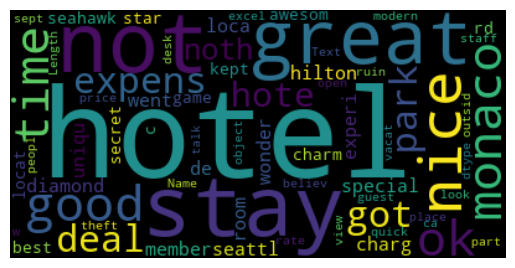

In [11]:
# Wordcloud shows summary of Text
wc = WordCloud(background_color='Black', stopwords= my_stopword).generate(str(review['Text']))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [12]:
tfidf = TfidfVectorizer()
tfidf = tfidf.fit_transform(review['Text'])

In [13]:
# Splitting DataSet into Train Test Data
X_train, X_test, y_train, y_test = train_test_split(review['Text'],review['Sentiment'], test_size=0.25, random_state=42)

In [14]:
clf = Pipeline([('TFIDF', TfidfVectorizer(max_features=5400, ngram_range=(1,1))),('clf',BaggingClassifier(base_estimator=LogisticRegression()))])

In [15]:
clf.fit(X_train,y_train)

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Pipeline(steps=[('TFIDF', TfidfVectorizer(max_features=5400)),
                ('clf',
                 BaggingClassifier(base_estimator=LogisticRegression()))])

In [16]:
# Predict the Test Data
y_pred = clf.predict(X_test)

In [17]:
# Check Accuracy
accuracy_score(y_test, y_pred)

0.8602381417138395

In [18]:
# Predict Review
clf.predict(['Its not good hotel fake'])

array(['Positive'], dtype=object)

In [19]:
new_review = "nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,"

afinn = Afinn()
new_review = preprocess(new_review)
words = new_review.split()

Positive = []
Negative = []
Neutral = []

for word in words:
    score = afinn.score(word)
    if score > 0:
        Positive.append(word)
    elif score <0:
        Negative.append(word)
    else:
        Neutral.append(word)

In [20]:
Positive

['nice',
 'good',
 'comfort',
 'great',
 'nice',
 'nice',
 'impress',
 'huge',
 'big',
 'warm',
 'bright',
 'great',
 'great']

In [21]:
Negative

['miss', 'hard', 'hard', 'broken', 'disappoint', 'drop', 'forgot', 'forgotten']

In [22]:
Neutral

['room',
 'not',
 'experi',
 'hotel',
 'monaco',
 'seattl',
 'hotel',
 'not',
 'level',
 'posit',
 'larg',
 'bathroom',
 'mediterranean',
 'suit',
 'bed',
 'pillowsattent',
 'housekeep',
 'staffneg',
 'ac',
 'unit',
 'malfunct',
 'stay',
 'desk',
 'disorgan',
 'separ',
 'wakeup',
 'call',
 'concierg',
 'busi',
 'touch',
 'not',
 'provid',
 'guidanc',
 'special',
 'request',
 'tv',
 'use',
 'ipod',
 'sound',
 'dock',
 'suit',
 'non',
 'function',
 'decid',
 'book',
 'mediterranean',
 'suit',
 'night',
 'weekend',
 'stay',
 'st',
 'choic',
 'rest',
 'parti',
 'fill',
 'comparison',
 'w',
 'spent',
 'night',
 'larger',
 'squar',
 'footag',
 'room',
 'soak',
 'tub',
 'whirlpool',
 'jet',
 'shower',
 'stay',
 'hotel',
 'arrang',
 'car',
 'servic',
 'price',
 'tip',
 'reason',
 'driver',
 'wait',
 'arriv',
 'checkin',
 'easi',
 'downsid',
 'room',
 'pick',
 'person',
 'jacuzi',
 'tub',
 'bath',
 'accessori',
 'salt',
 'bubbl',
 'bath',
 'not',
 'stay',
 'night',
 'got',
 'check',
 'voucher',

In [23]:
# Using pickle libraries Export a file in binary form.
pickle.dump(clf, open('Deploy.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl','wb'))